# Descriptive Analytics — KPI Scenarios (Solutions)

This notebook is **self-contained** and mirrors your Descriptive KPI hands‑on.  
We generate a shipment dataset and compute KPIs (OTIF, average cost, lead time) for the **baseline** and five **what‑if** changes:

1. **Mode Mix** — increase Air share (e.g., 15% → 40%).  
2. **SLA Policy** — reduce Road SLA from 6 → 5 days and recompute OTIF.  
3. **Cost Volatility** — add ±20% noise to *Cost_EUR* and compare averages.  
4. **Lead‑Time Cap** — cap `LeadTime_days` at 10 and observe OTIF inflation.  
5. **New Mode Added** — introduce **Rail** with intermediate speed/cost, then recompute KPIs.

> OTIF here is simplified as **On‑Time** percentage (in‑full assumed).

## 0) Imports & Helper Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

def simulate_shipments(n=1000, mix=None, slas=None, mode_params=None, base_cost=None, seed=7):
    """Simulate a shipment table with Mode, LeadTime_days, SLA_days, Cost_EUR, Late."""
    rng = np.random.default_rng(seed)
    modes = list(mix.keys())
    probs = np.array(list(mix.values()))
    mode = rng.choice(modes, p=probs, size=n)

    # draw lead times by mode
    lt = np.empty(n)
    for m in np.unique(mode):
        mu, sd, low, high = mode_params[m]  # mean, sd, min, max
        idx = np.where(mode == m)[0]
        lt[idx] = np.clip(rng.normal(mu, sd, size=len(idx)), low, high)

    # SLA by mode
    sla_map = slas.copy()
    sla = np.array([sla_map[m] for m in mode])

    # cost by mode with mild randomness
    cost_base = np.array([base_cost[m] for m in mode])
    cost = cost_base * (1 + rng.normal(0, 0.05, size=n))  # +/-5% noise

    df = pd.DataFrame({
        "Mode": mode,
        "LeadTime_days": lt.round(2),
        "SLA_days": sla,
        "Cost_EUR": cost.round(2)
    })
    df["OnTime"] = (df["LeadTime_days"] <= df["SLA_days"]).astype(int)
    return df

def kpis(df, title="KPIs"):
    otif = df["OnTime"].mean()
    cost_avg = df["Cost_EUR"].mean()
    lt_avg = df["LeadTime_days"].mean()
    by_mode = (df.groupby("Mode")["OnTime"].mean().rename("OTIF")
                 .to_frame().join(df.groupby("Mode")["Cost_EUR"].mean().rename("AvgCost")))
    print(f"{title}\nOTIF: {otif:.3f} | Avg Cost: €{cost_avg:.2f} | Avg LeadTime: {lt_avg:.2f} days\n")
    display(by_mode.round(3))
    return otif, cost_avg, lt_avg, by_mode

def bar_otif(df, title):
    by_mode = df.groupby("Mode")["OnTime"].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,3))
    plt.bar(by_mode.index, by_mode.values)
    plt.title(title); plt.ylabel("OTIF"); plt.ylim(0,1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

## 1) Baseline dataset

Baseline KPIs
OTIF: 0.932 | Avg Cost: €44.81 | Avg LeadTime: 6.30 days



,OTIF,AvgCost
Mode,,
Air,1.000,119.341
Road,0.949,35.102
Sea,0.842,20.058


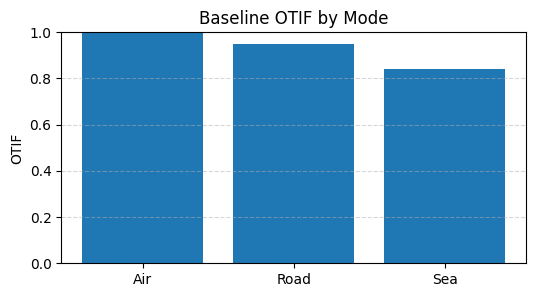

,Mode,LeadTime_days,SLA_days,Cost_EUR,OnTime
0,Air,3.70,4,122.22,1
1,Road,3.91,6,34.51,1
2,Road,4.76,6,35.58,1
3,Air,2.37,4,120.27,1
4,Air,2.36,4,117.91,1


In [2]:
# Baseline mode mix and parameters
mix_base = {"Air":0.15, "Road":0.60, "Sea":0.25}
slas_base = {"Air":4, "Road":6, "Sea":18}
# (mean, sd, min, max) lead time per mode
mode_params_base = {
    "Air": (2.0, 0.6, 0.5, 5.0),
    "Road": (4.0, 1.2, 1.0, 10.0),
    "Sea": (15.0, 3.0, 8.0, 30.0),
}
base_cost = {"Air": 120.0, "Road": 35.0, "Sea": 20.0}

df0 = simulate_shipments(n=2000, mix=mix_base, slas=slas_base, mode_params=mode_params_base, base_cost=base_cost, seed=11)
_ = kpis(df0, title="Baseline KPIs")
bar_otif(df0, "Baseline OTIF by Mode")
df0.head()

## 2) Scenario 1 — Mode Mix: increase Air share (15% → 40%)

S1 KPIs — Air Share 40%
OTIF: 0.951 | Avg Cost: €65.92 | Avg LeadTime: 5.35 days



,OTIF,AvgCost
Mode,,
Air,1.000,120.259
Road,0.952,35.007
Sea,0.851,20.029


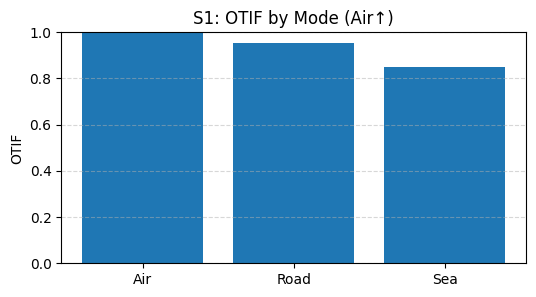

In [3]:
mix_s1 = {"Air":0.40, "Road":0.40, "Sea":0.20}
df1 = simulate_shipments(n=2000, mix=mix_s1, slas=slas_base, mode_params=mode_params_base, base_cost=base_cost, seed=12)
_ = kpis(df1, title="S1 KPIs — Air Share 40%") 
bar_otif(df1, "S1: OTIF by Mode (Air↑)")

## 3) Scenario 2 — SLA Policy: Road SLA 6 → 5 days

S2 KPIs — Road SLA tightened to 5 days
OTIF: 0.840 | Avg Cost: €44.81 | Avg LeadTime: 6.30 days



,OTIF,AvgCost
Mode,,
Air,1.000,119.341
Road,0.798,35.102
Sea,0.842,20.058


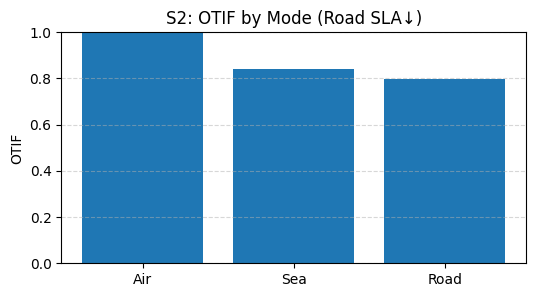

In [4]:
df2 = df0.copy()
df2.loc[df2["Mode"]=="Road", "SLA_days"] = 5
df2["OnTime"] = (df2["LeadTime_days"] <= df2["SLA_days"]).astype(int)
_ = kpis(df2, title="S2 KPIs — Road SLA tightened to 5 days")
bar_otif(df2, "S2: OTIF by Mode (Road SLA↓)")

## 4) Scenario 3 — Cost Volatility: ±20% on Cost_EUR

In [5]:
df3 = df0.copy()
noise = rng.uniform(-0.20, 0.20, size=len(df3))
df3["Cost_EUR"] = (df3["Cost_EUR"] * (1 + noise)).round(2)
_ = kpis(df3, title="S3 KPIs — Cost ±20% volatility")

S3 KPIs — Cost ±20% volatility
OTIF: 0.932 | Avg Cost: €44.83 | Avg LeadTime: 6.30 days



,OTIF,AvgCost
Mode,,
Air,1.000,119.367
Road,0.949,35.151
Sea,0.842,19.992


## 5) Scenario 4 — Lead‑Time Cap at 10 days

S4 KPIs — Cap LeadTime at 10 days (illustrative)
OTIF: 0.969 | Avg Cost: €44.81 | Avg LeadTime: 5.09 days



,OTIF,AvgCost
Mode,,
Air,1.000,119.341
Road,0.949,35.102
Sea,1.000,20.058


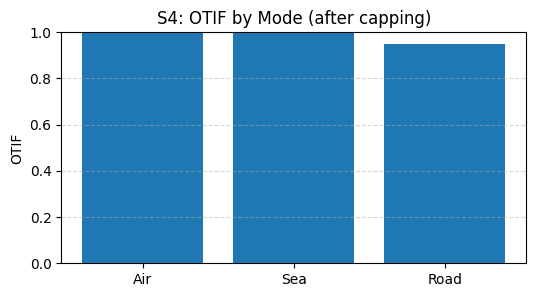

In [6]:
df4 = df0.copy()
df4["LeadTime_days"] = np.minimum(df4["LeadTime_days"], 10)  # **Warning**: policy can inflate OTIF
df4["OnTime"] = (df4["LeadTime_days"] <= df4["SLA_days"]).astype(int)
_ = kpis(df4, title="S4 KPIs — Cap LeadTime at 10 days (illustrative)")
bar_otif(df4, "S4: OTIF by Mode (after capping)")

## 6) Scenario 5 — Add 'Rail' (intermediate speed/cost)

S5 KPIs — Rail added (mix 20%)
OTIF: 0.889 | Avg Cost: €47.47 | Avg LeadTime: 6.73 days



,OTIF,AvgCost
Mode,,
Air,1.000,119.915
Rail,0.711,28.095
Road,0.952,34.987
Sea,0.822,19.968


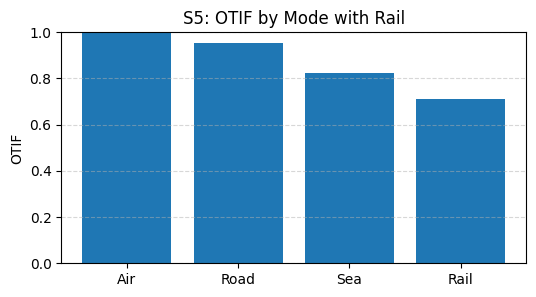

In [7]:
# Extend definitions
slas_s5 = slas_base | {"Rail": 9}
mode_params_s5 = mode_params_base | {"Rail": (8.0, 1.8, 4.0, 14.0)}
base_cost_s5 = base_cost | {"Rail": 28.0}

# Choose a new mix including Rail
mix_s5 = {"Air":0.20, "Road":0.40, "Sea":0.20, "Rail":0.20}

def simulate_with_rail(n=2000, seed=13):
    rng = np.random.default_rng(seed)
    modes = list(mix_s5.keys())
    probs = np.array(list(mix_s5.values()))
    mode = rng.choice(modes, p=probs, size=n)
    lt = np.empty(n)
    for m in np.unique(mode):
        mu, sd, low, high = mode_params_s5[m]
        idx = np.where(mode == m)[0]
        lt[idx] = np.clip(rng.normal(mu, sd, size=len(idx)), low, high)
    sla = np.array([slas_s5[m] for m in mode])
    cost = np.array([base_cost_s5[m] for m in mode]) * (1 + rng.normal(0, 0.05, size=n))
    df = pd.DataFrame({"Mode": mode, "LeadTime_days": lt.round(2), "SLA_days": sla, "Cost_EUR": cost.round(2)})
    df["OnTime"] = (df["LeadTime_days"] <= df["SLA_days"]).astype(int)
    return df

df5 = simulate_with_rail()
_ = kpis(df5, title="S5 KPIs — Rail added (mix 20%)")
bar_otif(df5, "S5: OTIF by Mode with Rail")

## 7) Scenario Comparison Summary

In [8]:
def summarize(df, label):
    otif = df['OnTime'].mean()
    cost = df['Cost_EUR'].mean()
    lt = df['LeadTime_days'].mean()
    return pd.Series({'OTIF': otif, 'AvgCost': cost, 'AvgLeadTime': lt}, name=label)

summary = pd.concat([
    summarize(df0, 'Baseline'),
    summarize(df1, 'S1 Air 40%'),
    summarize(df2, 'S2 Road SLA=5'),
    summarize(df3, 'S3 Cost ±20%'),
    summarize(df4, 'S4 LT Cap=10'),
    summarize(df5, 'S5 +Rail (20%)')
], axis=1).T.round(3)

summary

,OTIF,AvgCost,AvgLeadTime
Baseline,0.932,44.807,6.302
S1 Air 40%,0.951,65.921,5.354
S2 Road SLA=5,0.840,44.807,6.302
S3 Cost ±20%,0.932,44.825,6.302
S4 LT Cap=10,0.969,44.807,5.092
S5 +Rail (20%),0.890,47.466,6.732
